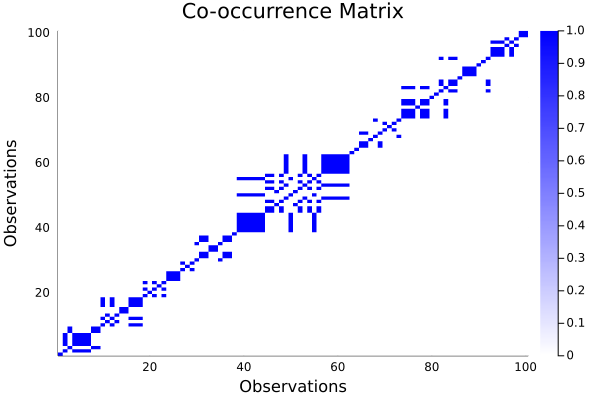

In [1]:
include("../ntl.jl")
import Random

using LinearAlgebra
Random.seed!(1)

data_covariance = Matrix{Float64}(0.01I, 2, 2)
prior_covariance = Matrix{Float64}(I, 2, 2)
prior_mean = Vector{Float64}(zeros(2))
data_parameters = Ntl.Models.GaussianParameters(data_covariance, prior_mean, prior_covariance)

psi_prior = Vector{Float64}([1, 1])
phi_prior = Vector{Float64}([1, 1])
geometric_arrival = Ntl.Models.GeometricArrivals(prior=phi_prior, sample_parameter_posterior=true)
ntl_cluster_parameters = Ntl.Models.NtlParameters(psi_prior, geometric_arrival)

mixture_model = Ntl.Models.Mixture(ntl_cluster_parameters, data_parameters)
n = 100
mixture = Ntl.Generate.generate(mixture_model, n=n)
data = Matrix(transpose(Matrix(mixture[:, 2:end])))
training_data = data[:, 1:n]
true_clustering = mixture[:, 1]
true_number_of_clusters = length(unique(true_clustering))
Ntl.Plot.plot_co_occurrence_matrix(true_clustering)

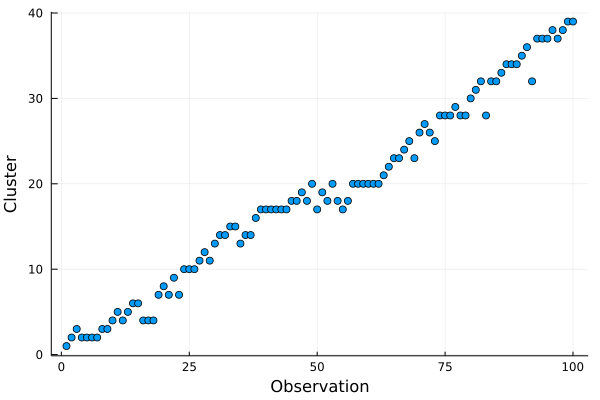

In [2]:
Ntl.Plot.plot_assignments(true_clustering)

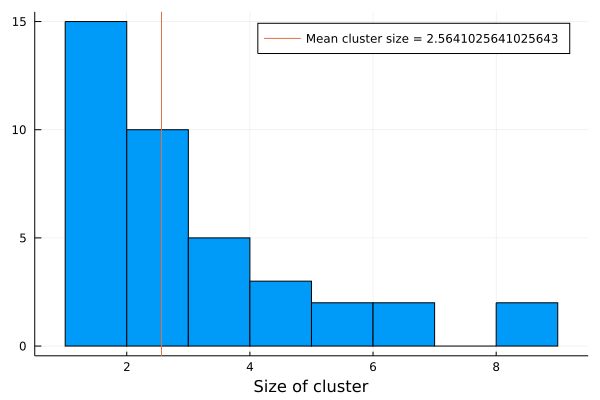

In [3]:
Ntl.Plot.plot_cluster_sizes_histogram(true_clustering)

In [4]:
ntl_cluster_parameters = Ntl.Models.NtlParameters(psi_prior, geometric_arrival)
gibbs_sampler = Ntl.Samplers.GibbsSampler(num_iterations=2000, num_burn_in=0, 
                                          assignment_types=["random", "all same cluster", "all different clusters"])
gibbs_output = Ntl.Fitter.fit(training_data, mixture_model, gibbs_sampler)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


Dict{String, Array} with 3 entries:
  "assignments"       => [1 1 … 1 1; 1 2 … 2 2; … ; 81 99 … 99 99; 74 99 … 99 9…
  "arrival posterior" => [0.106169 0.0198247 0.981764; 0.402033 0.262951 0.6208…
  "log likelihood"    => [-6919.69 -6654.8 -6919.84; -6989.21 -6968.46 -6946.55…

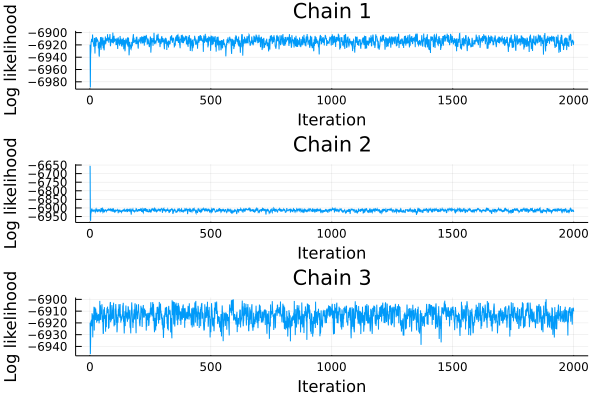

In [5]:
Ntl.Plot.plot_log_likelihoods(gibbs_output["log likelihood"])

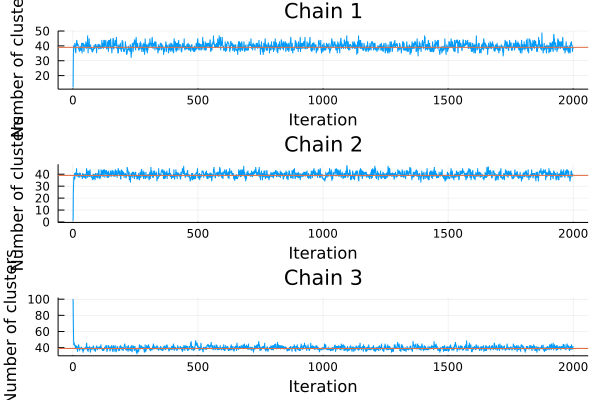

In [6]:
Ntl.Plot.plot_num_clusters(gibbs_output["assignments"], true_number=true_number_of_clusters)

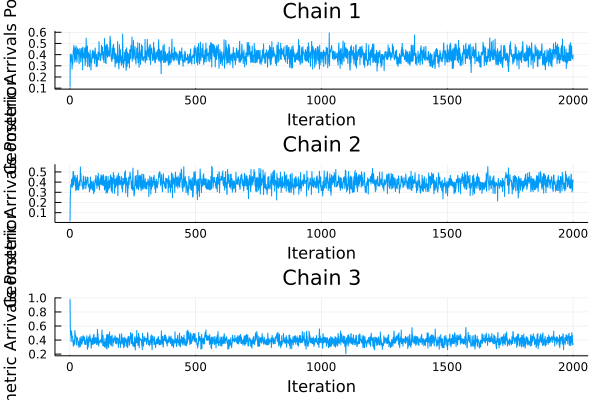

In [7]:
Ntl.Plot.plot_trace(gibbs_output["arrival posterior"], ylabel="Geometric Arrivals Posterior")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


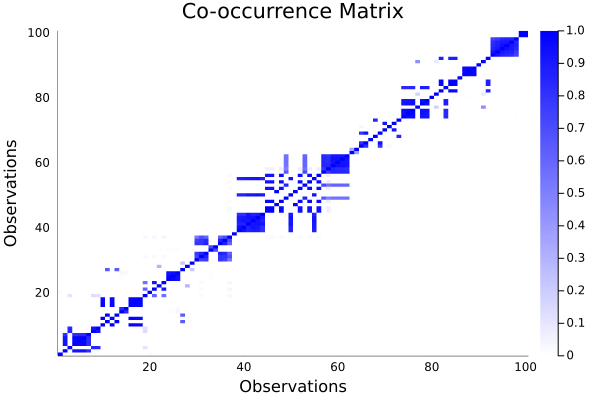

In [8]:
Ntl.Plot.plot_co_occurrence_matrix(gibbs_output["assignments"][:, :, 1], num_burn_in=500)

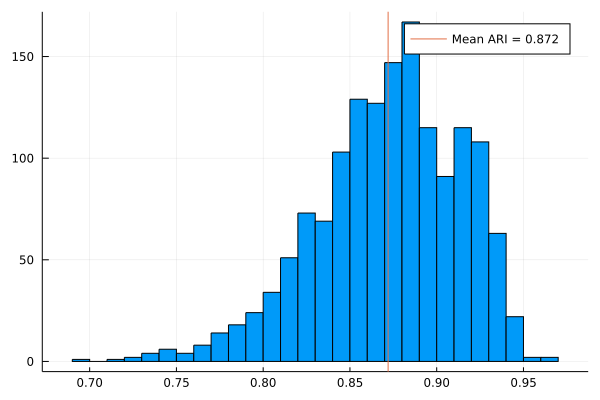

In [9]:
Ntl.Plot.plot_ari_posterior_distribution(true_clustering, gibbs_output["assignments"][:, :, 1], num_burn_in=500)

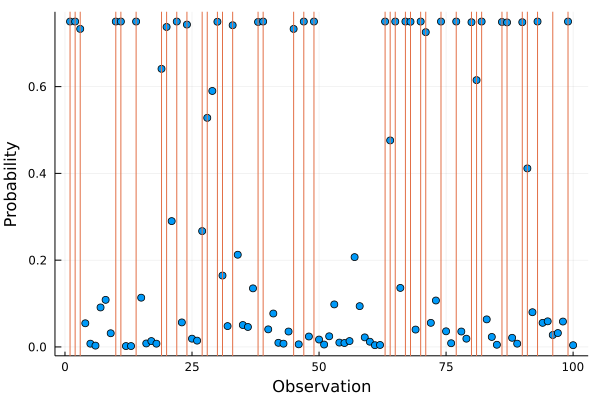

In [10]:
Ntl.Plot.plot_arrival_posterior_probabilities(gibbs_output["assignments"][:, :, 1], true_clustering, num_burn_in=500)

In [11]:
gibbs_map_estimate = Ntl.Utils.map_estimate(gibbs_output["assignments"][:, :, 1], gibbs_output["log likelihood"][:, 1], num_burn_in=500)
gibbs_map_ari = Ntl.Utils.adjusted_rand_index(gibbs_map_estimate, true_clustering)
println("MAP Estimate ARI = $gibbs_map_ari")

MAP Estimate ARI = 0.9241241790949285


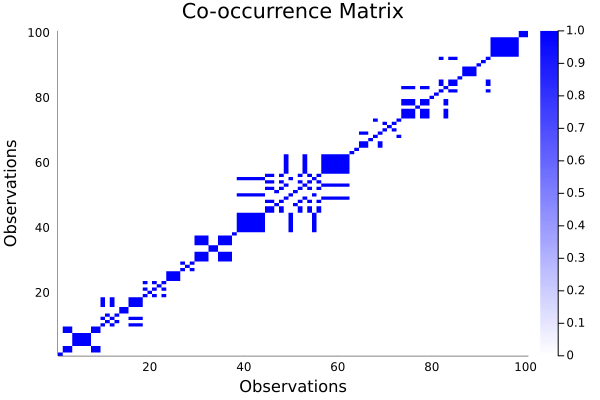

In [12]:
Ntl.Plot.plot_co_occurrence_matrix(gibbs_map_estimate)

In [13]:
gibbs_minbinder_estimate = Ntl.Utils.minbinder(gibbs_output["assignments"][:, :, 1], num_burn_in=500)
gibbs_minbinder_ari = Ntl.Utils.adjusted_rand_index(gibbs_minbinder_estimate, true_clustering)
println("MinBinder estimate ARI = $gibbs_minbinder_ari")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
┌ Warning: RCall.jl: Loading required package: lpSolve
└ @ RCall /Users/seanla/.julia/packages/RCall/3mHXJ/src/io.jl:160


MinBinder estimate ARI = 0.9377062383840845


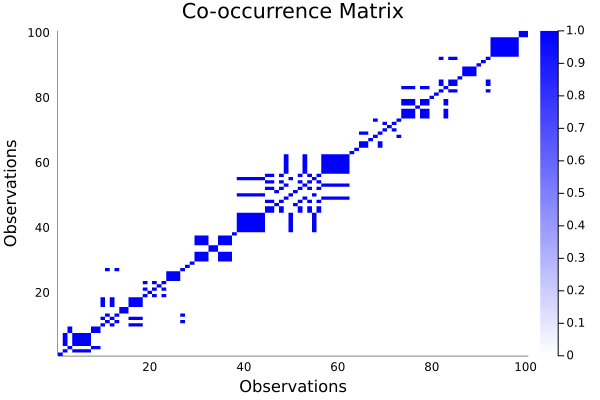

In [14]:
Ntl.Plot.plot_co_occurrence_matrix(gibbs_minbinder_estimate)

In [15]:
gibbs_minVI_estimate = Ntl.Utils.minVI(gibbs_output["assignments"][:, :, 1], num_burn_in=500)
gibbs_minVI_ari = Ntl.Utils.adjusted_rand_index(gibbs_minVI_estimate, true_clustering)
println("Min VI Estimate ARI = $gibbs_minVI_ari")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Min VI Estimate ARI = 0.9346290429295698


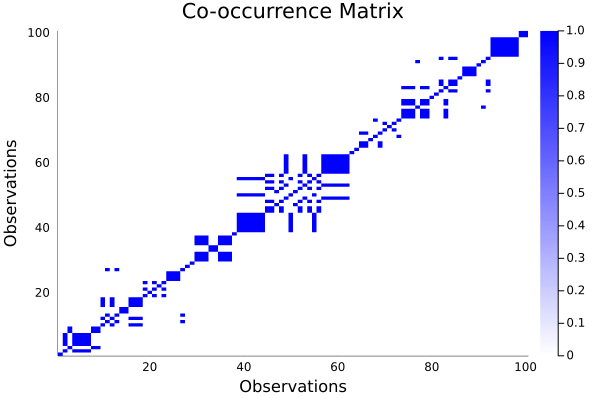

In [16]:
Ntl.Plot.plot_co_occurrence_matrix(gibbs_minVI_estimate)

In [41]:
metropolis_hastings_sampler = Ntl.Samplers.MetropolisHastingsSampler(num_iterations=10000, num_burn_in=0, proposal_radius=5, skip=1, adaptive=true,
                                                                     assignment_types=["random", "all same cluster", "all different clusters"])
mcmc_output = Ntl.Fitter.fit(training_data, mixture_model, metropolis_hastings_sampler) 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
Progress:  15%|██████▎                                  |  ETA: 0:00:37

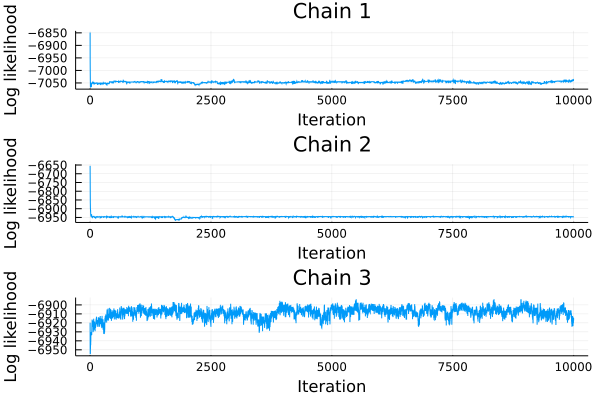

In [18]:
Ntl.Plot.plot_log_likelihoods(mcmc_output["log likelihood"])

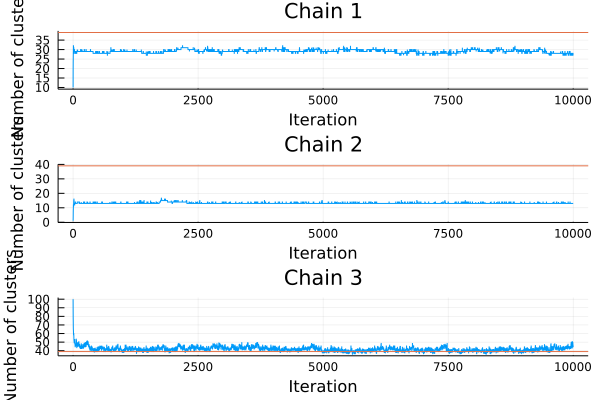

In [19]:
Ntl.Plot.plot_num_clusters(mcmc_output["assignments"], true_number=true_number_of_clusters)

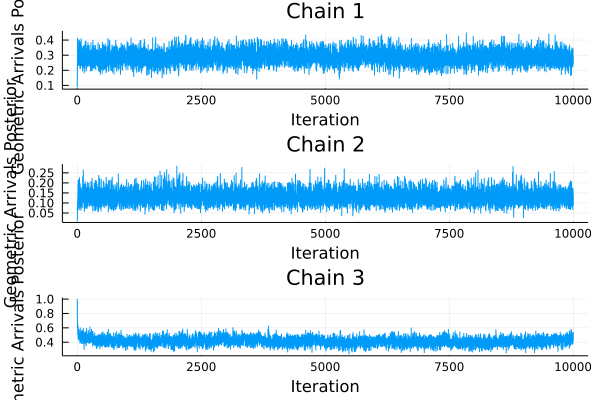

In [20]:
Ntl.Plot.plot_trace(mcmc_output["arrival posterior"], ylabel="Geometric Arrivals Posterior")

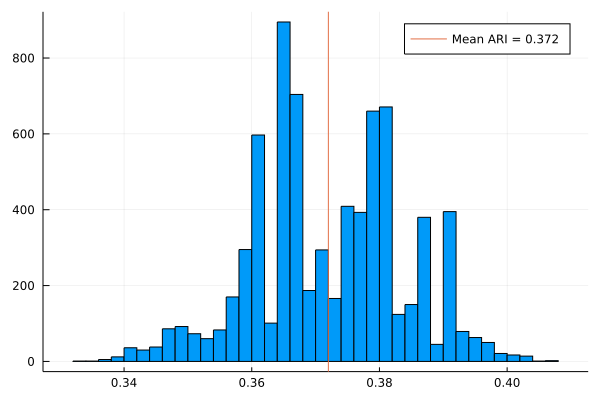

In [21]:
Ntl.Plot.plot_ari_posterior_distribution(true_clustering, mcmc_output["assignments"][:, :, 1], num_burn_in=2600)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


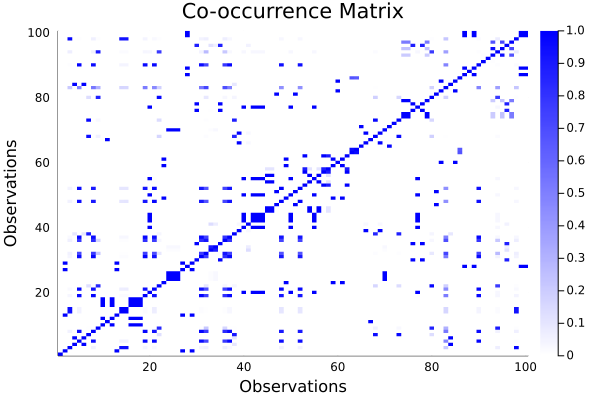

In [22]:
Ntl.Plot.plot_co_occurrence_matrix(mcmc_output["assignments"][:, :, 1], num_burn_in=2600)

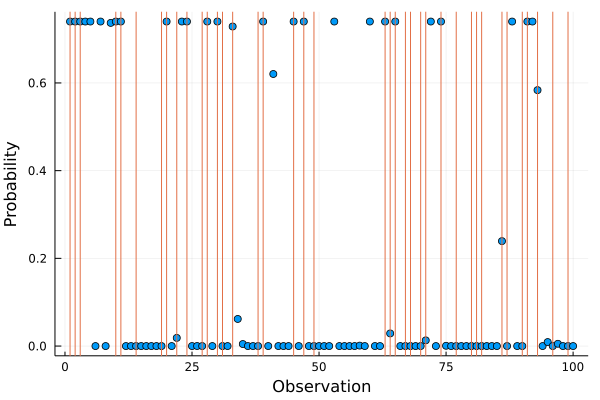

In [23]:
Ntl.Plot.plot_arrival_posterior_probabilities(mcmc_output["assignments"][:, :, 1], true_clustering, num_burn_in=2600)

In [24]:
mcmc_map_estimate = Ntl.Utils.map_estimate(mcmc_output["assignments"][:, :, 1], mcmc_output["log likelihood"][:, 1], num_burn_in=2600)
mcmc_map_ari = Ntl.Utils.adjusted_rand_index(mcmc_map_estimate, true_clustering)
println("MAP Estimate ARI = $mcmc_map_ari")

MAP Estimate ARI = 0.34527667321189703


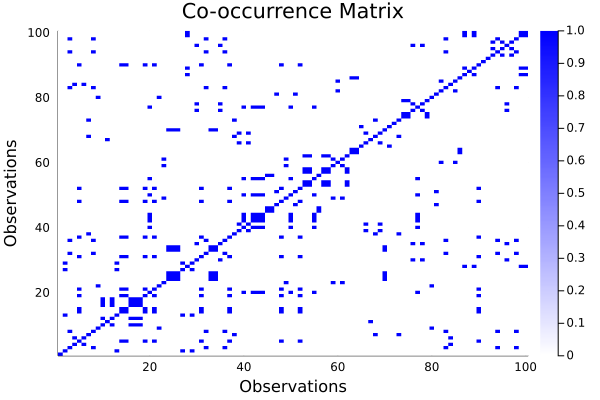

In [25]:
Ntl.Plot.plot_co_occurrence_matrix(mcmc_map_estimate)

In [26]:
mcmc_minbinder_estimate = Ntl.Utils.minbinder(mcmc_output["assignments"][:, :, 1], num_burn_in=2600)
mcmc_minbinder_ari = Ntl.Utils.adjusted_rand_index(mcmc_minbinder_estimate, true_clustering)
println("MinBinder estimate ARI = $mcmc_minbinder_ari")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


MinBinder estimate ARI = 0.37875225392914347


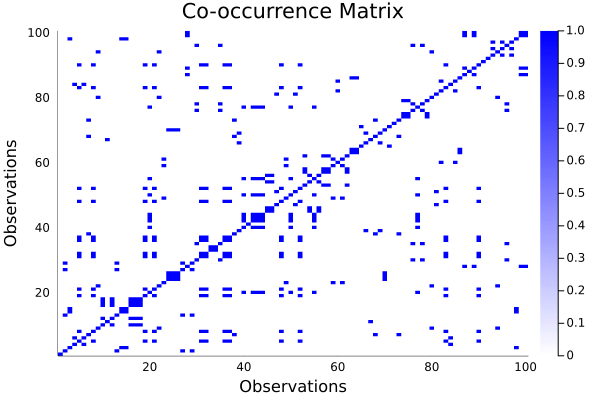

In [27]:
Ntl.Plot.plot_co_occurrence_matrix(mcmc_minbinder_estimate)

In [28]:
mcmc_minVI_estimate = Ntl.Utils.minVI(mcmc_output["assignments"][:, :, 1], num_burn_in=2600)
mcmc_minVI_ari = Ntl.Utils.adjusted_rand_index(mcmc_minVI_estimate, true_clustering)
println("Min VI Estimate ARI = $mcmc_minVI_ari")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Min VI Estimate ARI = 0.37875225392914347


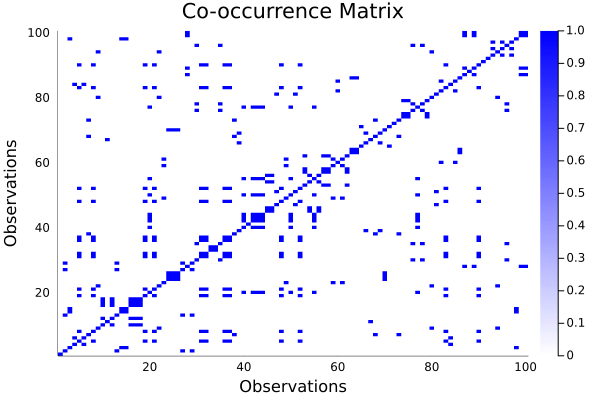

In [29]:
Ntl.Plot.plot_co_occurrence_matrix(mcmc_minVI_estimate)

In [30]:
dp_cluster_parameters = Ntl.Models.DpParameters(1)
dp_mixture = Ntl.Models.Mixture(dp_cluster_parameters, data_parameters)
gibbs_sampler = Ntl.Samplers.GibbsSampler(num_iterations=10000, num_burn_in=0, 
                                          assignment_types=["random", "all same cluster", "all different clusters"])
dp_output = Ntl.Fitter.fit(training_data, dp_mixture, gibbs_sampler)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


Dict{String, Array} with 2 entries:
  "assignments"    => [1 1 … 1 1; 1 2 … 2 2; … ; 99 99 … 99 99; 74 99 … 99 99]…
  "log likelihood" => [-6822.51 -6650.2 -7278.98; -7044.59 -7023.55 -7120.35; ……

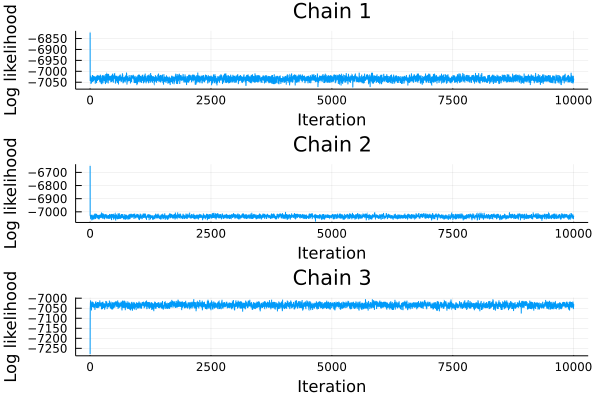

In [31]:
Ntl.Plot.plot_log_likelihoods(dp_output["log likelihood"])

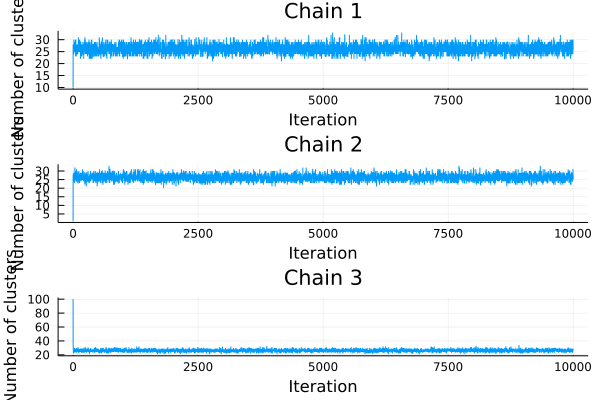

In [32]:
Ntl.Plot.plot_num_clusters(dp_output["assignments"])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


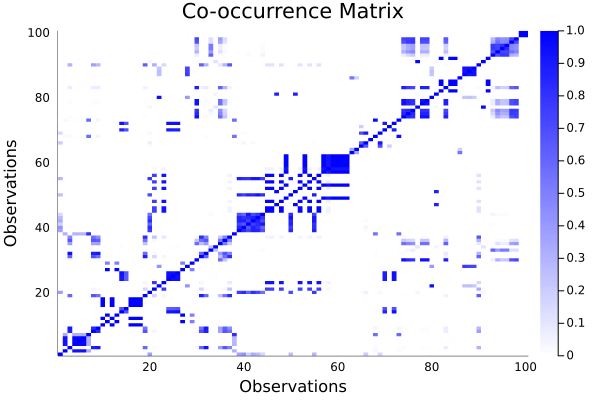

In [33]:
Ntl.Plot.plot_co_occurrence_matrix(dp_output["assignments"][:, :, 1], num_burn_in=1000)

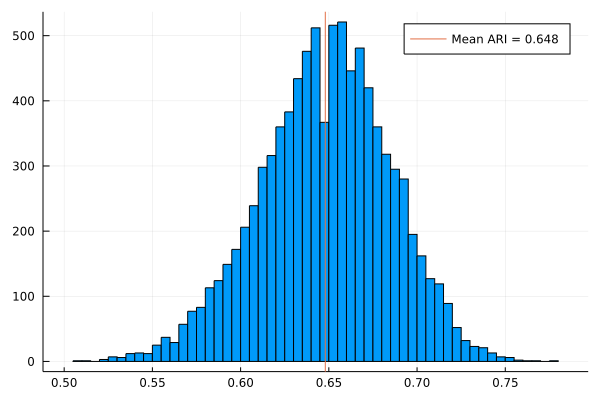

In [34]:
Ntl.Plot.plot_ari_posterior_distribution(true_clustering, dp_output["assignments"][:, :, 1], num_burn_in=1000)

In [35]:
dp_map_estimate = Ntl.Utils.map_estimate(dp_output["assignments"][:, :, 1], dp_output["log likelihood"][:, 1], num_burn_in=1000)
dp_map_ari = Ntl.Utils.adjusted_rand_index(dp_map_estimate, true_clustering)
println("MAP Estimate ARI = $dp_map_ari")

MAP Estimate ARI = 0.6202641778798971


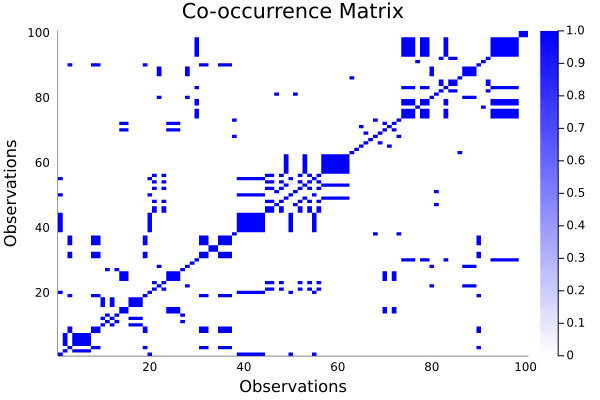

In [36]:
Ntl.Plot.plot_co_occurrence_matrix(dp_map_estimate)

In [37]:
dp_minbinder_estimate = Ntl.Utils.minbinder(dp_output["assignments"][:, :, 1], num_burn_in=1000)
dp_minbinder_ari = Ntl.Utils.adjusted_rand_index(dp_minbinder_estimate, true_clustering)
println("MinBinder estimate ARI = $dp_minbinder_ari")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


MinBinder estimate ARI = 0.6744363473731286


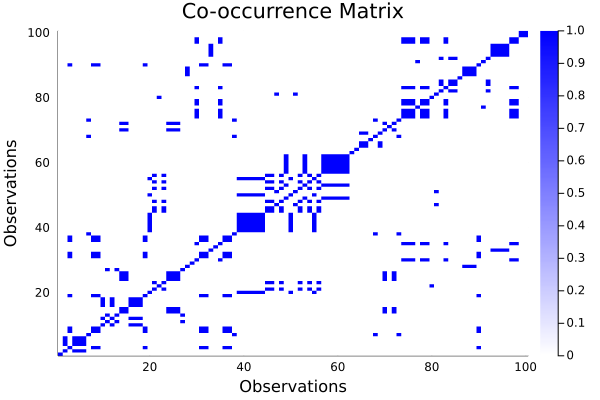

In [38]:
Ntl.Plot.plot_co_occurrence_matrix(dp_minbinder_estimate)

In [39]:
dp_minVI_estimate = Ntl.Utils.minVI(dp_output["assignments"][:, :, 1], num_burn_in=1000)
dp_minVI_ari = Ntl.Utils.adjusted_rand_index(dp_minVI_estimate, true_clustering)
println("Min VI Estimate ARI = $dp_minVI_ari")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Min VI Estimate ARI = 0.6584242072323591


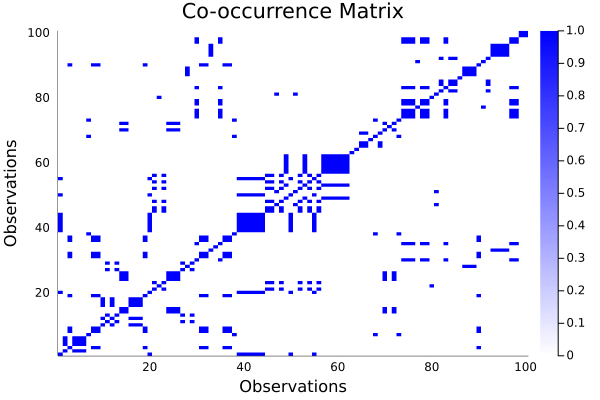

In [40]:
Ntl.Plot.plot_co_occurrence_matrix(dp_minVI_estimate)